### Fine-tuning Vision Transformer for Image Classification

In [ ]:
%%capture
! pip install datasets transforms

# Load a dataset
- Data là tập dữ liệu về lá tốt cho sức khỏe và không tốt cho sức khỏe

In [ ]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Xem dữ liệu, thì một dữ liệu sẽ có 3 phần:
1. image: a PIL image
2. image_file_path: đường dẫn tới ảnh
3. labels: số nguyên của nhãn

In [ ]:
# view data
ex = ds['train'][400]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F825F2B0A30>,
 'labels': 1}

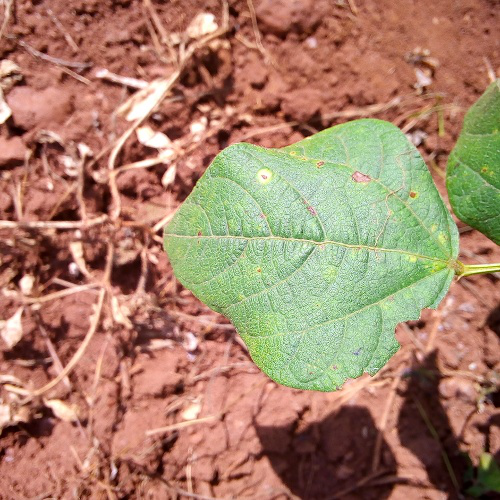

In [ ]:
image = ex['image']
image

Lấy tên label

In [ ]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [ ]:
# view tên labels
labels.int2str(ex['labels'])

'bean_rust'

# Visualize data

In [ ]:
%%capture
!pip install transformers

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

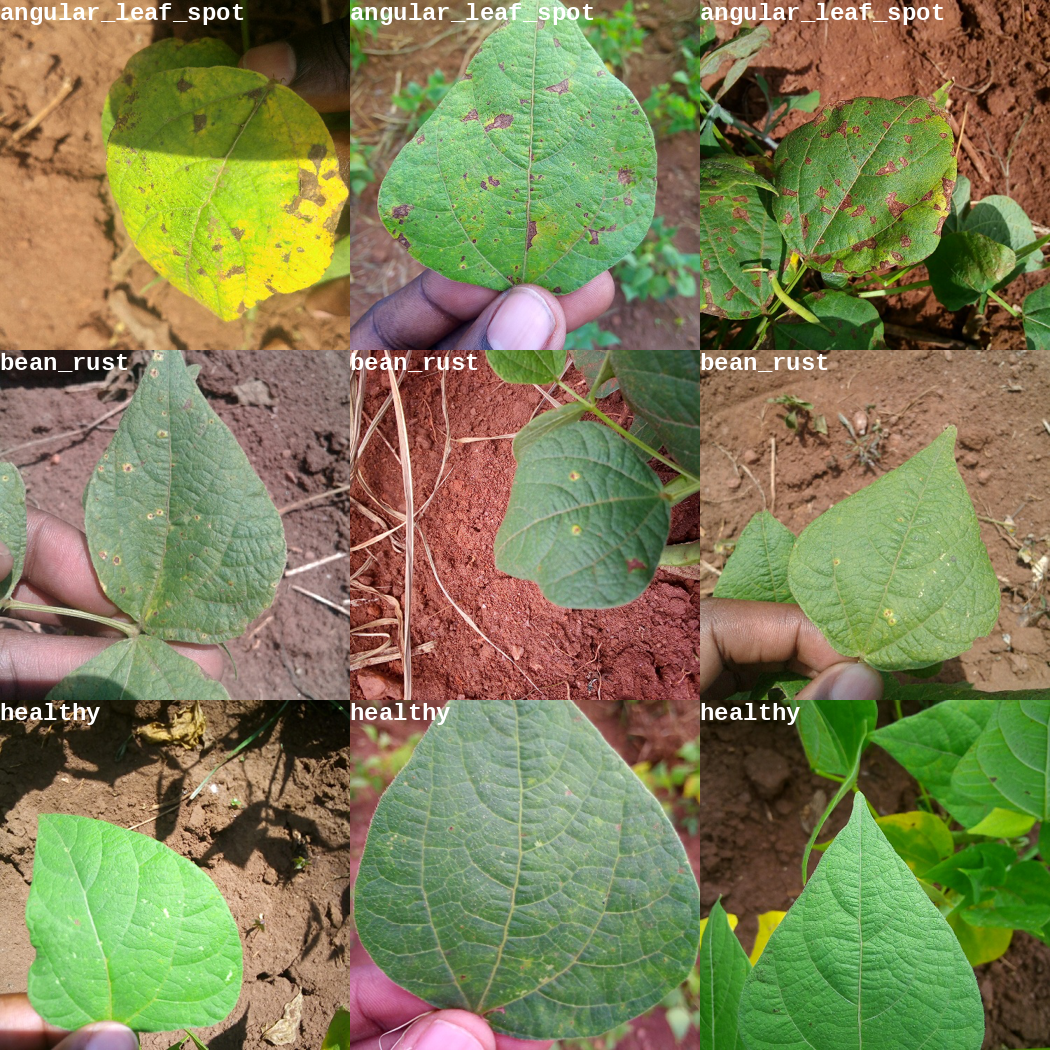

In [ ]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int=24, examples_per_class: int=3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):
        # lấy dữ liệu 1 nhãn, trộn, và lấy
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # plot
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box = box)
            draw.text(box, label, (255, 255, 255), font=font)
    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

### Loading ViT Feature Extractor
- Sử dụng mô hình của google trên hub

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# view model feature extractor
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
# 
feature_extractor(image, return_trnsors='pt')

{'pixel_values': [array([[[ 0.7882353 ,  0.67058825,  0.70980394, ..., -0.19215685,
         -0.12941176, -0.17647058],
        [ 0.7019608 ,  0.6       ,  0.6862745 , ..., -0.2862745 ,
         -0.1607843 , -0.1607843 ],
        [ 0.48235297,  0.4039216 ,  0.4666667 , ..., -0.19215685,
         -0.01960784,  0.02745104],
        ...,
        [ 0.3803922 ,  0.5294118 ,  0.48235297, ..., -0.827451  ,
         -0.81960785, -0.8039216 ],
        [ 0.09019613,  0.37254906,  0.3803922 , ..., -0.8666667 ,
         -0.84313726, -0.8509804 ],
        [-0.05098039,  0.27843142,  0.3176471 , ..., -0.85882354,
         -0.827451  , -0.827451  ]],

       [[ 0.4901961 ,  0.34901965,  0.3803922 , ..., -0.60784316,
         -0.5372549 , -0.58431375],
        [ 0.35686278,  0.20000005,  0.3176471 , ..., -0.7176471 ,
         -0.6       , -0.5921569 ],
        [ 0.04313731, -0.09019607,  0.05098045, ..., -0.6392157 ,
         -0.47450978, -0.42745095],
        ...,
        [-0.2235294 , -0.05098039, -

### Processing the Dataset

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [ ]:
ds = load_dataset('beans')

def transform(example_batch):
    # lấy danh sách hình ảnh và chuyển đổi thành pixel
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # bao gồm các nhãn
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
prepared_ds['test'][0:2]

{'pixel_values': tensor([[[[-0.0510, -0.0510, -0.1294,  ..., -0.3647, -0.2471, -0.0196],
          [-0.1529, -0.1059, -0.2000,  ..., -0.3020, -0.1922,  0.1294],
          [-0.1686, -0.1529, -0.1843,  ..., -0.3804,  0.0510,  0.4039],
          ...,
          [-0.3333, -0.3255, -0.2000,  ...,  0.0353, -0.0902, -0.2392],
          [-0.3176, -0.3569, -0.3412,  ..., -0.1451, -0.2078, -0.2000],
          [-0.2235, -0.2549, -0.2078,  ..., -0.1922, -0.1765, -0.1686]],

         [[ 0.1765,  0.1843,  0.1216,  ..., -0.6392, -0.5765, -0.3804],
          [ 0.0980,  0.1608,  0.0824,  ..., -0.5843, -0.5294, -0.2314],
          [ 0.1059,  0.1373,  0.1216,  ..., -0.6627, -0.2863,  0.0431],
          ...,
          [-0.6784, -0.6941, -0.5922,  ..., -0.2784, -0.3333, -0.3490],
          [-0.7020, -0.7333, -0.7098,  ..., -0.3725, -0.3882, -0.3412],
          [-0.6235, -0.6392, -0.5686,  ..., -0.3804, -0.3255, -0.3020]],

         [[-0.5922, -0.5843, -0.6784,  ..., -0.8588, -0.8431, -0.6627],
          [-0

### Training and Evaluation
1. Xác định một chức năng đối chiếu
2. Xác định hàm đo đánh giá. Được đánh giá về độ chính xác. Tạo hàm compute_metrics
3. Tải một điểm kiểm tra đào tạo trước
4. Xác định cấu tạo

# 1. Xác định một chức năng đối chiếu

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# 2. Hàm đánh giá
- Sử dụng accuracy từ datasets

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-17-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Tải mô hình và thêm num_labels vào init để đảm bảo mô hình đầu phân loại với số lượng đơn vị phù hợp

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name_or_path

'google/vit-base-patch16-224-in21k'

Thiết lập cấu hình

In [ ]:
%%capture
!pip install --upgrade accelerate
!pip install PartialState

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

# thiết lập trainer

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.173600,0.033353,1.000000
200,0.017100,0.092477,0.969925


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1367
  train_runtime            =  0:03:29.70
  train_samples_per_second =      19.723
  train_steps_per_second   =        1.24


In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0334
  eval_runtime            = 0:00:02.77
  eval_samples_per_second =     47.882
  eval_steps_per_second   =       6.12


In [ ]:
trainer

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
    print('0')
else:
    trainer.create_model_card(**kwargs)
    print('1')

1


In [ ]:
m = trainer.evaluate(prepared_ds['validation'][0])

In [ ]:
prepared_ds['validation'][0]

{'pixel_values': tensor([[[ 0.2471,  0.0353, -0.0275,  ...,  0.0353, -0.2784, -0.4353],
          [ 0.0980, -0.0353, -0.0588,  ..., -0.2706, -0.3804, -0.4196],
          [-0.1529, -0.2078, -0.1922,  ..., -0.4275, -0.4510, -0.4431],
          ...,
          [ 0.5451,  0.4824,  0.4431,  ...,  0.5059,  0.6078,  0.6471],
          [ 0.6549,  0.6157,  0.4824,  ...,  0.6157,  0.6471,  0.4039],
          [ 0.6706,  0.4824,  0.3647,  ...,  0.6627,  0.4510,  0.2078]],
 
         [[ 0.3961,  0.1843,  0.1216,  ...,  0.2235, -0.0588, -0.2235],
          [ 0.3333,  0.1686,  0.1137,  ..., -0.1529, -0.1765, -0.1922],
          [ 0.1216,  0.0431,  0.0118,  ..., -0.3647, -0.2941, -0.2627],
          ...,
          [ 0.0196, -0.0353, -0.0745,  ...,  0.2078,  0.3255,  0.3647],
          [ 0.1529,  0.0902, -0.0431,  ...,  0.3255,  0.3255,  0.0588],
          [ 0.1843, -0.0431, -0.1608,  ...,  0.3647,  0.1216, -0.1529]],
 
         [[-0.4745, -0.5922, -0.5686,  ..., -0.7333, -0.8824, -0.9843],
          [-

In [ ]:
trainer.save_model('model.pth')

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = '/content/model.pth'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
feature_extractor(image)

{'pixel_values': [array([[[ 0.7882353 ,  0.67058825,  0.70980394, ..., -0.19215685,
         -0.12941176, -0.17647058],
        [ 0.7019608 ,  0.6       ,  0.6862745 , ..., -0.2862745 ,
         -0.1607843 , -0.1607843 ],
        [ 0.48235297,  0.4039216 ,  0.4666667 , ..., -0.19215685,
         -0.01960784,  0.02745104],
        ...,
        [ 0.3803922 ,  0.5294118 ,  0.48235297, ..., -0.827451  ,
         -0.81960785, -0.8039216 ],
        [ 0.09019613,  0.37254906,  0.3803922 , ..., -0.8666667 ,
         -0.84313726, -0.8509804 ],
        [-0.05098039,  0.27843142,  0.3176471 , ..., -0.85882354,
         -0.827451  , -0.827451  ]],

       [[ 0.4901961 ,  0.34901965,  0.3803922 , ..., -0.60784316,
         -0.5372549 , -0.58431375],
        [ 0.35686278,  0.20000005,  0.3176471 , ..., -0.7176471 ,
         -0.6       , -0.5921569 ],
        [ 0.04313731, -0.09019607,  0.05098045, ..., -0.6392157 ,
         -0.47450978, -0.42745095],
        ...,
        [-0.2235294 , -0.05098039, -

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    '/content/model.pth'
)

In [ ]:
metrics = model.evaluate(prepared_ds['validation'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1614 in __getattr__           │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ViTForImageClassification' object has no attribute 'evaluate'